
# Data preparation
We combine the data, convert the labels for classification and apply augmentation

In [1]:
import os, sys, math, json
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow import keras
from tensorflow.keras import layers

np.random.seed(0)

IMAGE_SIZE = [32, 32]

In [2]:
df = pd.read_json('../data/labelled_data/prepared-samples-binary.json')

y = df['label'].to_numpy()
X = np.array(df['data'].to_list())
X = np.expand_dims(X, axis=3)
print(y.shape)
print(X.shape)

(200,)
(200, 32, 32, 1)


In [3]:
# Create train / val / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

In [4]:
# Simple CNN (sequential) Model

model = keras.Sequential(
    [
        keras.Input(shape=(32,32,1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(2, activation="softmax"),
    ]
)

model.compile(
optimizer='adam',
loss= 'sparse_categorical_crossentropy',
metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4

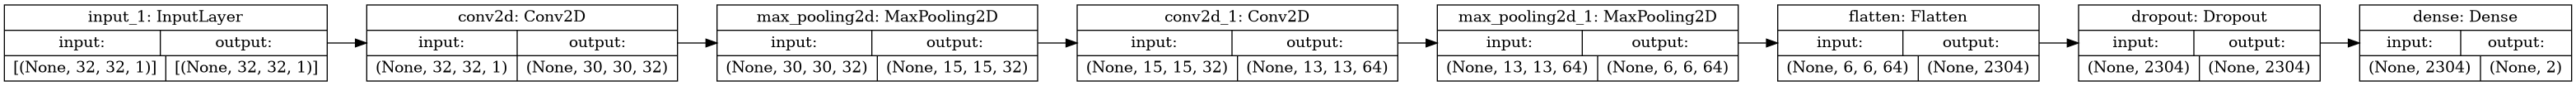

In [5]:
# Plot the model
# `rankdir='LR'` is to make the graph horizontal.
%matplotlib inline
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

Epoch 1/50
8/8 [==============================] - 1s 26ms/step - loss: 1.3124 - accuracy: 0.6417 - val_loss: 1.5046 - val_accuracy: 0.3500
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 1.0128 - accuracy: 0.5500 - val_loss: 0.8436 - val_accuracy: 0.6500
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.8637 - accuracy: 0.6167 - val_loss: 0.6483 - val_accuracy: 0.6500
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.6914 - accuracy: 0.5333 - val_loss: 0.7015 - val_accuracy: 0.4250
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.6802 - accuracy: 0.6000 - val_loss: 0.6559 - val_accuracy: 0.6500
Epoch 6/50
8/8 [==============================] - 0s 15ms/step - loss: 0.6896 - accuracy: 0.6083 - val_loss: 0.6450 - val_accuracy: 0.6500
Epoch 7/50
8/8 [==============================] - 0s 10ms/step - loss: 0.6774 - accuracy: 0.6250 - val_loss: 0.6574 - val_accuracy: 0.6500
Epoch 8/50
8/8 [=============

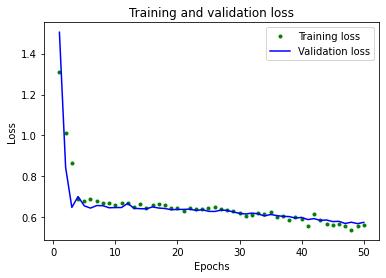

Test loss: 0.5925219058990479 / Test accuracy: 0.699999988079071


In [6]:
# Fit the model
EPOCHS = 50
BATCH_SIZE = 16
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Plot training history
plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("simpleCnn-sequential-eval.png")
plt.show()

# Generate generalization metrics
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

In [7]:


label = {1: 'Human',
         0: 'No Human'}

pred = model.predict(X_test)

classes = np.argmax(pred, axis = 1)
print(classes)

[1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0]


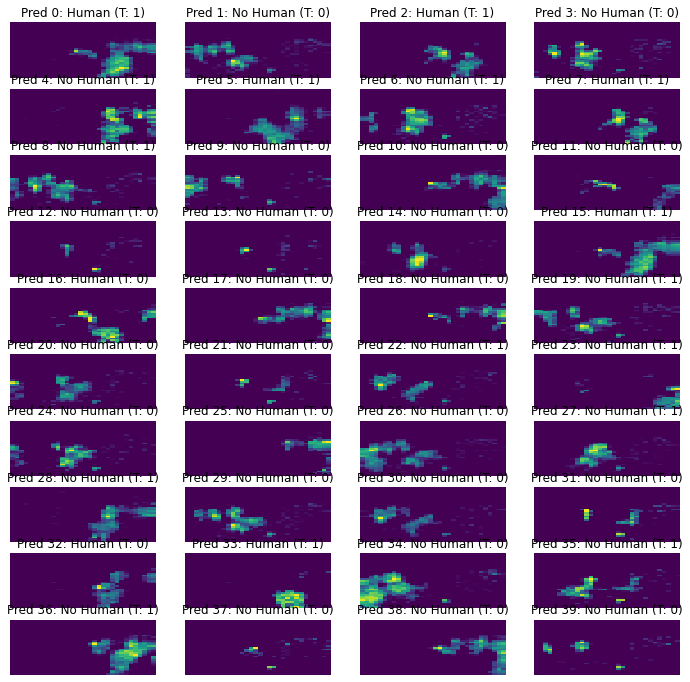

In [8]:
# Print predictions
%matplotlib inline
n=4 # pics per row

fig, axes = plt.subplots(nrows=int(len(X_test)/n), ncols=n, figsize=(n*3, n*3), num='Predictions')

for ax, idx in zip(axes.reshape(-1), range(len(X_test))): 
    ax.set_axis_off()
    ax.set_title('Pred %i: %s (T: %i)' % (idx, label[classes[idx]], y_test[idx]))
    ax.imshow(X_test[idx].reshape(32, 32), interpolation='nearest', aspect='auto')

In [9]:
# Export saved model
keras.models.save_model(model, "simpleCnn-sequential-binary.h5")